In [19]:
import sys
from finenv.env_stocktrading import StockTradingEnv
from finenv.env_stocktrading_cut import StockTradingEnv2
from finenv.preprocessors import FeatureEngineer, data_split
import pandas as pd
import pickle 
import psutil
import ray, time
ray._private.utils.get_system_memory = lambda: psutil.virtual_memory().total
from ray.tune.registry import register_env
from gymnasium.wrappers import EnvCompatibility
from ray.rllib.agents import ppo
from ray.rllib.algorithms.ddpg.ddpg import DDPGConfig
from ray.rllib.algorithms.td3 import TD3Config
from ray.rllib.algorithms.algorithm import Algorithm


In [23]:
csv = False
if csv:
    trade = pd.read_csv('dataset/train_data.csv')
    trade = trade.set_index(trade.columns[0])
    trade.index.names = ['']
    INDICATORS = ['macd','boll_ub','boll_lb','rsi_30','cci_30','dx_30','close_30_sma','close_60_sma']

else: 
    trade = pd.read_csv('dataset/qqq_train.csv')
    trade = trade.set_index(trade.columns[0])
    trade.index.names = ['']
    INDICATORS = ['macd','rsi','cci','adx']
    
stock_dimension = len(trade.tic.unique())
buy_cost_list = sell_cost_list = [0.001] * stock_dimension    
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")
trade.head(5)    

Stock Dimension: 1, State Space: 7


,date,open,high,low,close,volume,tic,macd,rsi,cci,adx
0,2019-05-13 09:30,182.29,182.38,182.25,182.38,11815.0,QQQ,-0.582177,43.104095,-20.197978,24.748197
1,2019-05-13 09:45,182.36,182.45,182.35,182.37,21178.0,QQQ,-0.534645,42.996066,-9.957917,24.433568
2,2019-05-13 10:00,182.43,182.43,182.36,182.39,1695.0,QQQ,-0.489717,43.302124,-0.642754,24.141412
3,2019-05-13 10:15,182.41,182.41,182.08,182.13,5691.0,QQQ,-0.469677,40.274792,-5.585598,24.297941
4,2019-05-13 10:30,182.22,182.35,181.97,181.97,22182.0,QQQ,-0.461386,38.491404,-2.240645,24.605519


In [24]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension
env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-2
}
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = None, risk_indicator_col= 'vix', **env_kwargs)
e_trade_gym2 = StockTradingEnv2(df = trade, **env_kwargs)

In [25]:
def env_creator_trading(env_config):
    # env_config is passed as {} and defaults are set here
    df = env_config.get('df', trade)  # changed from the training environment
    hmax = env_config.get('hmax', 100)
    initial_amount = env_config.get('initial_amount', 1000000)
    num_stock_shares = env_config.get('num_stock_shares', [0] * stock_dimension)
    buy_cost_pct = env_config.get('buy_cost_pct', buy_cost_list)
    sell_cost_pct = env_config.get('sell_cost_pct', sell_cost_list)
    state_space = env_config.get('state_space', 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension)
    stock_dim = env_config.get('stock_dim', stock_dimension)
    tech_indicator_list = env_config.get('tech_indicator_list', INDICATORS)
    action_space = env_config.get('action_space', stock_dimension)
    reward_scaling = env_config.get('reward_scaling', 1e-2)
    return EnvCompatibility(StockTradingEnv(
        df=df,
        hmax=hmax,
        initial_amount=initial_amount,
        num_stock_shares=num_stock_shares,
        buy_cost_pct=buy_cost_pct,
        sell_cost_pct=sell_cost_pct,
        state_space=state_space,
        stock_dim=stock_dim,
        tech_indicator_list=tech_indicator_list,
        action_space=action_space,
        reward_scaling=reward_scaling,
    ))

In [26]:
ray.shutdown()
#ray.init(address='auto')

In [27]:
# registering the environment to ray
register_env("finrl", env_creator_trading)
#trainer = ppo.PPOTrainer(env='finrl', config=config)
#config = ppo.PPOConfig()
config = TD3Config()
config = config.environment(env_config={'hmax':100,'initial_amount':1000000})
config = config.rollouts(num_rollout_workers=0) 
config = config.framework(framework="torch")
config['seed'] = 0 
config["model"]["fcnet_hiddens"] = [256, 256, 256]
trader = config.build(env='finrl') 

2023-04-08 10:26:45,202	INFO worker.py:1544 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8266 
2023-04-08 10:26:48,074	WARNING env.py:156 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
2023-04-08 10:26:48,078	WARNING env.py:166 -- Your env reset() method appears to take 'seed' or 'return_info' arguments. Note that these are not yet supported in RLlib. Seeding will take place using 'env.seed()' and the info dict will not be returned from reset.
/home/ga_aiot/anaconda3/envs/finrl/lib/python3.8/site-packages/gymnasium/spaces/box.py:227: UserWarning: WARN: Casting input x to numpy array.
  logger.warn("Casting input x to numpy array.")
2023-04-08 10:26:51,220	INFO trainable.py:172 -- Trainable.setup took 10.052 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.


In [28]:
#load model
cwd_checkpoint = 'model/org_td3_230408_53_wt/checkpoint_000000'
trader = Algorithm.from_checkpoint(cwd_checkpoint)

/home/ga_aiot/anaconda3/envs/finrl/lib/python3.8/site-packages/gymnasium/spaces/box.py:227: UserWarning: WARN: Casting input x to numpy array.
  logger.warn("Casting input x to numpy array.")


In [29]:
def DRL_prediction(model, environment):
    start = time.time()
    """make a prediction"""
    state = environment.reset()
    for i in range(len(environment.df.index.unique())):
        action = model.compute_single_action(state, explore=False)
        #print(f'Test Took:{(time.time()-start)}s')
        state, reward, done, _ = environment.step(action)
        if i == (len(environment.df.index.unique()) - 1):
            account_memory = environment.save_asset_memory()
            actions_memory = environment.save_action_memory()
        if done:
            break
    print(f'Test Took:{(time.time()-start):.3f}s | Average Time:{((time.time()-start)/len(environment.df.index.unique())):.6f}s/Iterations')
    return account_memory, actions_memory

In [30]:
df_account_value, df_actions = DRL_prediction(model=trader, environment = e_trade_gym)
print('Final account value:'+str(df_account_value.iloc[-1]['account_value']))
model_filename = cwd_checkpoint[14:-18]
df_actions.to_csv(f'results/{model_filename}.csv', index=True)
df_actions.head(100)

Test Took:61.907s | Average Time:0.002343s/Iterations
Final account value:1765467.6976700004


,date,actions
0,2019-05-13 09:30,[100]
1,2019-05-13 09:45,[100]
2,2019-05-13 10:00,[100]
3,2019-05-13 10:15,[100]
4,2019-05-13 10:30,[100]
...,...,...
95,2019-05-16 13:00,[0]
96,2019-05-16 13:15,[0]
97,2019-05-16 13:30,[0]
98,2019-05-16 13:45,[0]


In [31]:
#Total Trades
counts = (df_actions > 0).sum()
tdays = int(df_actions.shape[0])
print(f'Trades:{counts.sum()}\nTrade Days:{tdays}\nTrades Per Day:{counts.sum()/tdays:.2f}')
df_actions.sum()

TypeError: '>' not supported between instances of 'str' and 'int'

In [15]:
import datetime
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')
perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./results/"+"perf_stats_all"+now+'.csv')

==============Get Backtest Results===========
Annual return          0.173916
Cumulative returns     0.863194
Annual volatility      0.281723
Sharpe ratio           0.711335
Calmar ratio           0.532854
Stability              0.693879
Max drawdown          -0.326386
Omega ratio            1.136140
Sortino ratio          1.009260
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.993582
Daily value at risk   -0.034698
dtype: float64


/home/ga_aiot/anaconda3/envs/finrl/lib/python3.8/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(
/home/ga_aiot/anaconda3/envs/finrl/lib/python3.8/site-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()


In [17]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^NDX", 
        start = df_account_value.loc[0,'date'],
        end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')

==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (977, 8)
Annual return          0.150447
Cumulative returns     0.721784
Annual volatility      0.278863
Sharpe ratio           0.643124
Calmar ratio           0.423042
Stability              0.498593
Max drawdown          -0.355631
Omega ratio            1.120914
Sortino ratio          0.902704
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.898492
Daily value at risk   -0.034422
dtype: float64


/home/ga_aiot/anaconda3/envs/finrl/lib/python3.8/site-packages/finrl/meta/preprocessor/yahoodownloader.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)
/home/ga_aiot/anaconda3/envs/finrl/lib/python3.8/site-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()


==============Compare to NDX===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (977, 8)


/home/ga_aiot/anaconda3/envs/finrl/lib/python3.8/site-packages/finrl/meta/preprocessor/yahoodownloader.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)
/home/ga_aiot/anaconda3/envs/finrl/lib/python3.8/site-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/home/ga_aiot/anaconda3/envs/finrl/lib/python3.8/site-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


Start date,2019-05-13
End date,2023-03-29
Total months,46
,Backtest
Annual return,17.392%
Cumulative returns,86.319%
Annual volatility,28.172%
Sharpe ratio,0.71
Calmar ratio,0.53
Stability,0.69
Max drawdown,-32.639%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,32.64,2021-12-27,2022-10-14,NaT,NaN
1,31.31,2020-02-19,2020-03-20,2020-06-05,78
2,10.19,2020-09-02,2020-09-23,2020-11-16,54
3,9.75,2021-02-16,2021-03-08,2021-04-01,33
4,8.16,2019-07-24,2019-08-05,2019-10-25,68


/home/ga_aiot/anaconda3/envs/finrl/lib/python3.8/site-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/home/ga_aiot/anaconda3/envs/finrl/lib/python3.8/site-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/home/ga_aiot/anaconda3/envs/finrl/lib/python3.8/site-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/home/ga_aiot/anaconda3/envs/finrl/lib/python3.8/site-packages/pyfolio/timeseries.py:541: FutureWarning: The default dtype for empty Series will be 'ob

Stress Events,mean,min,max
New Normal,0.08%,-13.11%,10.04%


/home/ga_aiot/anaconda3/envs/finrl/lib/python3.8/site-packages/pyfolio/timeseries.py:1230: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  period = returns_dupe.loc[start:end]


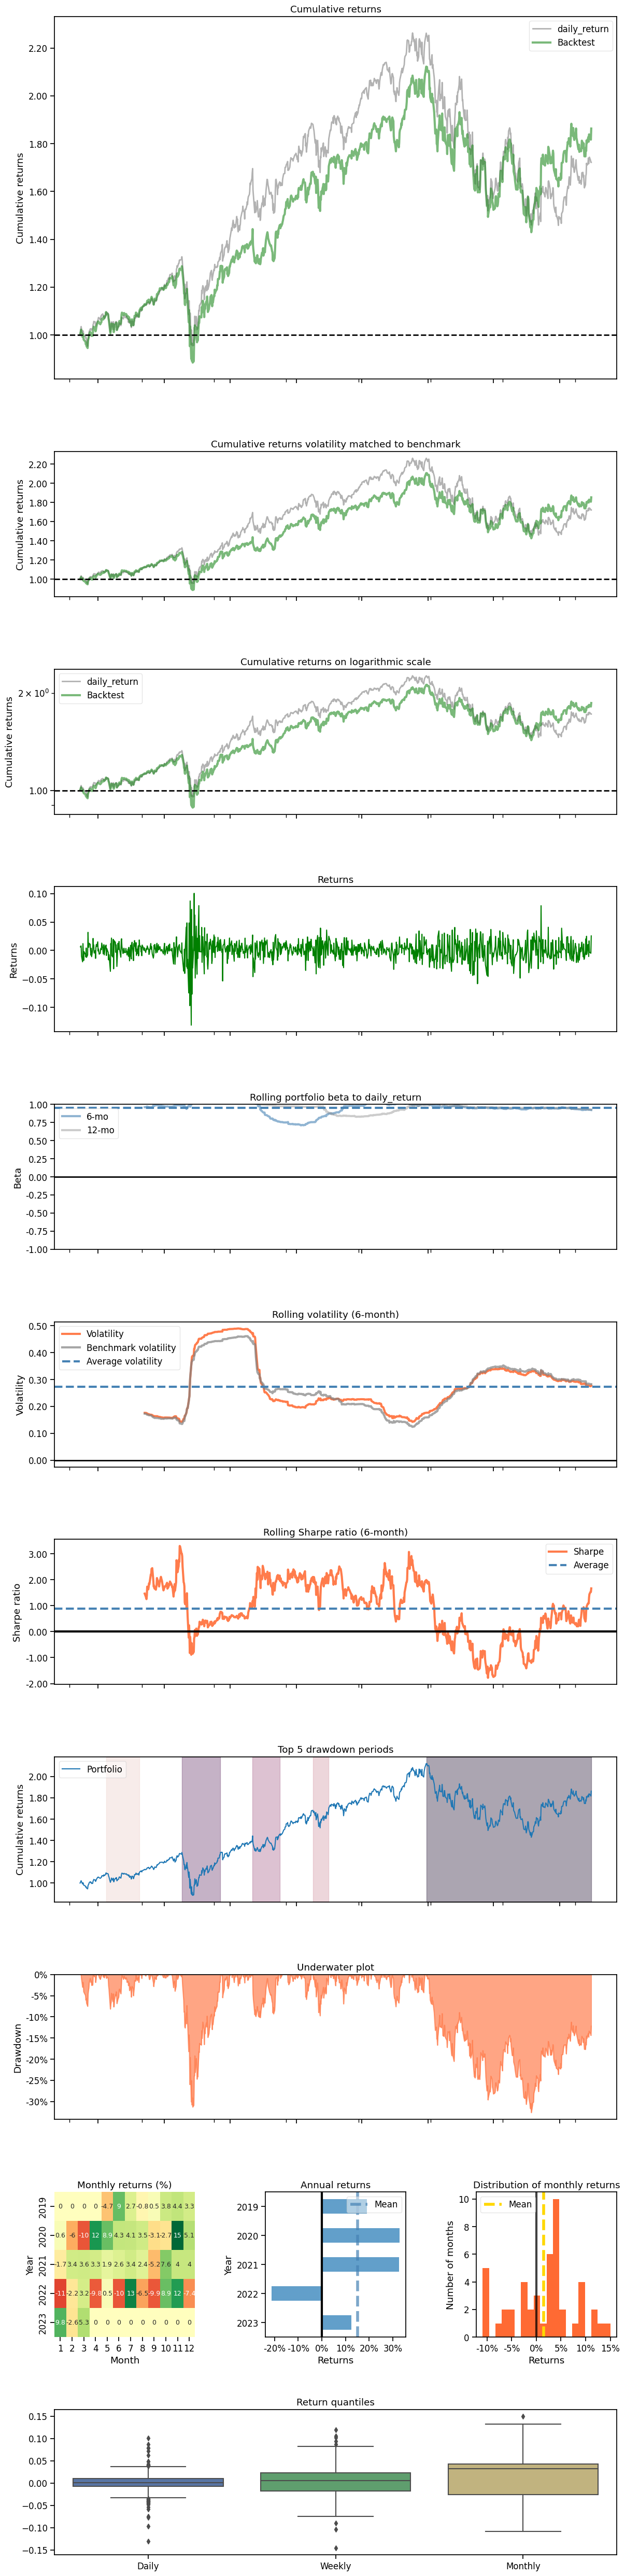

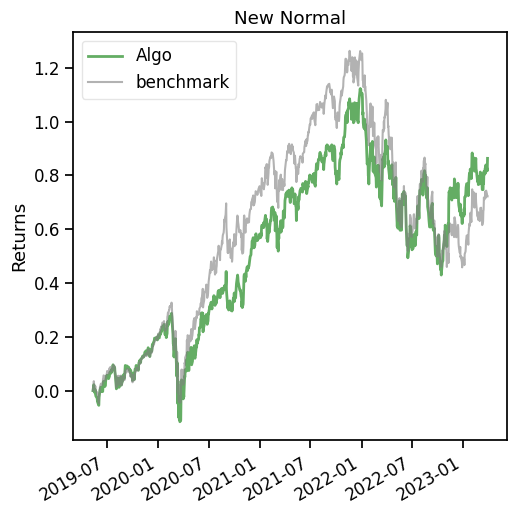

In [16]:
print("==============Compare to NDX===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value, 
             baseline_ticker = '^NDX', 
             baseline_start = df_account_value.loc[0,'date'],
             baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])